> ref: https://onlinelibrary.wiley.com/doi/abs/10.1002/mrm.28992

In [ ]:
import os, time, logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def vis_square(data, title=''):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""

    # normalize data for display
    # data = (data - data.min()) / (data.max() - data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
                (0, 1), (0, 1))  # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant',
                  constant_values=max(1, data.max()))  # pad with ones (white)

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    plt.imshow(data, cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title)

    return n

def vis_square_annotate(data, rois=[], title=''):
    fig, ax = plt.subplots(figsize=(12, 12), dpi=100)
    n = vis_square(data, title)
    padding = 1  # XXX - vis_square pad one white pixel between images

    for r in rois:
        rect = Rectangle((rois[r][1] * (data.shape[1] + padding) + rois[r][2],
                          rois[r][0] * (data.shape[2] + padding) + rois[r][3]),
                         rois[r][4], rois[r][5], edgecolor='g', fill=False)

        roi = data[rois[r][0] * n + rois[r][1],
              rois[r][3]:(rois[r][3] + rois[r][5]),
              rois[r][2]:(rois[r][2] + rois[r][4])]

        # plt.figure()
        # plt.imshow(roi, cmap='gray')
        # plt.axis('off')

        ax.add_patch(rect)
        ax.annotate('%s Mean:%.4f,StdDev:%.4f' % (r, roi.mean(), roi.std()),
                    rect.get_xy(), color='r', weight='normal',
                    fontsize=10, ha='left', va='baseline')
        
def reconImagesByFFT(kdata, size):
    if isinstance(size, int):
        size = (size, size)

    try:
        # experiments, echoes, slices, views, views2, samples = kdata.shape
        idata = np.fft.fftshift(np.fft.ifftn(kdata, s=(size[0], kdata.shape[4], size[1]),
                                             axes=(3, 4, 5)),
                                axes=(3, 4, 5))
    except Exception as e:
        return []

    idata = np.abs(idata)
    idata /= idata.max()

    images = []
    for e in range(idata.shape[0]):
        for k in range(idata.shape[1]):
            for s in range(idata.shape[2]):
                for v2 in range(idata.shape[4]):
                    images.append(idata[e, k, s, :, v2, :])

    return images
    
def _yanglei(kdatas, nbin=8, v=0):
    kdata_obj = kdatas[0]
    kdata_nos = [_ for _ in kdatas[1:] if _ is not None]

    if len(kdata_nos) <= 0:
        return kdata_obj

    if (not isinstance(nbin, int)) or nbin <= 0:
        logging.warning('The nbin(=%d) must be an integer greater than 0.' % (nbin,))
        return kdata_obj

    npb = kdata_nos[0].shape[5] // nbin

    if (nbin * npb) != kdata_nos[0].shape[5]:
        logging.warning('The nbin(=%d) must be divisible by number of samples(=%d).' % (nbin, kdata_nos[0].shape[5]))
    else:
        idata_obj = np.fft.fft(kdata_obj)
        idata_nos = np.array([np.fft.fft(kdata_nos[i]) for i in range(len(kdata_nos))])

        X = idata_nos[:, 0, 0, 0, v, 0, :]
        y = idata_obj[0, 0, 0, v, 0, :]
        c = np.zeros((idata_nos.shape[0], nbin), dtype=y.dtype)

        for i in range(c.shape[1]):
            rng = range(i * npb, (i + 1) * npb)
            _ = np.linalg.lstsq(X[:, rng].T, y[rng], rcond=None)
            c[:, i] = _[0]

        idata_obj -= np.reshape(np.sum(c[:, None, None, None, None, None, :, None] *
                                       idata_nos.reshape((idata_nos.shape[0], idata_nos.shape[1], idata_nos.shape[2],
                                                          idata_nos.shape[3], idata_nos.shape[4], idata_nos.shape[5],
                                                          c.shape[1], -1)),
                                       axis=0),
                                idata_obj.shape)

        kdata_obj = np.fft.ifft(idata_obj)

    return kdata_obj

def yanglei(prim_coil, ext_coils, nbin=8, v=0):
    views, samples = prim_coil.shape
    prim_coil = prim_coil.reshape(1, 1, 1, views, 1, samples)
    ext_coils = ext_coils.reshape(-1, 1, 1, 1, views, 1, samples)
    kdatas = [prim_coil, *ext_coils]
    return _yanglei(kdatas, nbin, v).reshape(views, samples)
    
class DataLoader:
    @staticmethod
    def parse_mrd(mrd):
        if not isinstance(mrd, bytes):
            return None
        if len(mrd) < 512:
            return None

        samples = int(0).from_bytes(mrd[0:4], byteorder='little', signed=True)
        views = int(0).from_bytes(mrd[4:8], byteorder='little', signed=True)
        views2 = int(0).from_bytes(mrd[8:12], byteorder='little', signed=True)
        slices = int(0).from_bytes(mrd[12:16], byteorder='little', signed=True)
        # 16-18 Unspecified
        datatype = int(0).from_bytes(mrd[18:20], byteorder='little', signed=True)
        # 20-152 Unspecified
        echoes = int(0).from_bytes(mrd[152:156], byteorder='little', signed=True)
        experiments = int(0).from_bytes(mrd[156:160], byteorder='little', signed=True)

        nele = experiments * echoes * slices * views * views2 * samples

        if datatype & 0xf == 0:
            dt = 'u1'
            eleSize = 1
        elif datatype & 0xf == 1:
            dt = 'i1'
            eleSize = 1
        elif datatype & 0xf == 2:
            dt = 'i2'
            eleSize = 2
        elif datatype & 0xf == 3:
            dt = 'i2'
            eleSize = 2
        elif datatype & 0xf == 4:
            dt = 'i4'
            eleSize = 4
        elif datatype & 0xf == 5:
            dt = 'f4'
            eleSize = 4
        elif datatype & 0xf == 6:
            dt = 'f8'
            eleSize = 8
        else:
            logging.error('Unknown data type in the MRD file!')
            return None
        if datatype & 0x10:
            eleSize *= 2

        #
        # XXX - The value of NO_AVERAGES in PPR cannot be used to
        #       calculate the data size.
        #       Maybe COMPLETED_AVERAGES? ref. p14 of the manual
        #
        posPPR = mrd.rfind(b'\x00')
        if posPPR == -1:
            logging.error('Corrupted MRD file!')
            return None
        posPPR += 1
        dataSize = posPPR - 512 - 120
        if dataSize < nele * eleSize:
            logging.error('Corrupted MRD file!')
            return None

        ndata = dataSize // (nele * eleSize)
        data = []

        offset = 512
        for i in range(ndata):
            x = np.frombuffer(mrd[offset:],
                              dtype=[('re', '<' + dt), ('im', '<' + dt)] if (datatype & 0x10) else ('<' + dt),
                              count=nele)
            if dt in ('f4', 'f8'):
                pass
            else:
                x = x.astype(np.float32)
                print("???")

            if datatype & 0x10:
                if dt in ('f8',):
                    x = x.view(np.complex128)
                else:
                    x = x.view(np.complex64)

            x = x.reshape((experiments, echoes, slices, views, views2, samples))

            offset += nele * eleSize

            data.append(x)

        if offset != posPPR - 120:
            logging.warning('Corrupted MRD file!')

        output = {}
        output['description'] = mrd[256:512].decode('cp437', errors='ignore').rstrip('\0')
        output['data'] = data
        output['sampleInfoFilePath'] = mrd[(posPPR - 120):posPPR].decode('cp437', errors='ignore').rstrip('\0')
        # output['pulseq'] = SmisPulseq(mrd[posPPR:])

        return output

    def __init__(self, root, set_id=1):
        if not os.path.exists(root):
            logging.error('The root path does not exist!')
            return
        if not os.path.exists(os.path.join(root, 'set {}'.format(set_id))):
            logging.error('The set path does not exist!')
            return
        self.root = root
        self.set_id = set_id

    def load_data(self, data_type, exp_id=1):
        path = os.path.join(self.root, f'set {self.set_id}', f'{data_type} data', f'exp{exp_id}')  # set 1，exp1注意空格
        if not os.path.exists(path):
            logging.error('The experiment path does not exist!')
            return None

        with open(os.path.join(path, f'{data_type}1.mrd'), 'rb') as f:
            prim_mrd_data = self.parse_mrd(f.read())['data'][0]

        ext_mrds_data = []
        i = 2
        while True:
            data_path = os.path.join(path, f'{data_type}{i}.mrd')
            if not os.path.exists(data_path):
                break
            with open(data_path, 'rb') as f:
                ext_mrds_data.append(self.parse_mrd(f.read())['data'][0])
            i += 1

        # reshape
        experiments, echoes, slices, views, views2, samples = prim_mrd_data.shape
        return [
            [
                prim_mrd_data[0, 0, 0, :, i, :],
                np.array(ext_mrds_data)[:, 0, 0, 0, :, i, :]
            ]
            for i in range(views2)]

    def set_set_id(self, set_id):
        self.set_id = set_id

class EDITER:
    @staticmethod
    def calculate_h(E, prim_coil):
        h = np.linalg.pinv(E) @ prim_coil.flatten()
        return h

    def cluster(self, H, threshold=0.5):
        # normalize
        H = H / np.linalg.norm(H, axis=0)

        H_conj_T = H.conj().T
        C = np.dot(H_conj_T, H)
        C_threshold = (C >= threshold).astype(int)

        groups_range = []
        r = 0
        while r < self.W:
            l = r
            while r < self.W and C_threshold[l, r] == 1:
                r += 1
            groups_range.append([l, r])
        return groups_range

    def __init__(self, W, window_size=(3, 1)):
        self.W = W
        self.window_size = window_size
        self.model = None

    # 生成EMI_conv_matrix
    def EMI_conv_matrix(self, ext_coils):
        delta_kx, delta_ky = self.window_size
        lines = []
        kx, ky = ext_coils[0].shape
        if kx < delta_kx or ky < delta_ky:
            print(f'error: kx({kx}) < delta_kx({delta_kx}) or ky({ky}) < delta_ky({delta_ky})')
            return

        for i_x in range(kx - delta_kx + 1):
            for i_y in range(ky - delta_ky + 1):
                line = np.concatenate(tuple(
                    d[i_x:i_x + delta_kx, i_y:i_y + delta_ky].flatten() for d in ext_coils
                ))
                lines.append(line)
        E = np.vstack(tuple(lines))
        return E

    def divide_data_into_temporal_groups(self, prim_coil, ext_colils, ranges=None):
        if ranges is None:
            width = ext_colils.shape[1]
            if width % self.W != 0:
                print(f"kx 必须是 W 的整数倍！ kx: {width}, W: {self.W}")
                return
            sub_width = width // self.W
            ranges = [[i * sub_width, (i + 1) * sub_width] for i in range(self.W)]

        return [[prim_coil[:, i:j], ext_colils[:, :, i:j]] for i, j in ranges]

    def get_H(self, datas):
        H = []
        for prim_coil, ext_coils in datas:
            E = self.EMI_conv_matrix(ext_coils)
            prim_coil = self.trim_edges(prim_coil)
            H.append(self.calculate_h(E, prim_coil))
        H = np.array(H).reshape(len(datas), -1).T
        return H

    def get_clustered_H(self, H, prim_coil, ext_coils):
        clustered_groups_range = self.cluster(H)
        width = ext_coils.shape[1] // self.W
        clustered_groups_range = [[l * width, r * width] for l, r in clustered_groups_range]

        clustered_groups = [[prim_coil[:, i:j], ext_coils[:, :, i:j]] for i, j in clustered_groups_range]
        clustered_H = [self.calculate_h(self.EMI_conv_matrix(ext_coils), self.trim_edges(prim_coil))
                       for prim_coil, ext_coils in clustered_groups]
        return np.array(clustered_H).T, clustered_groups_range

    def train(self, prim_coil, ext_coils):
        groups = self.divide_data_into_temporal_groups(prim_coil, ext_coils)

        H = self.get_H(groups)

        H, H_range = self.get_clustered_H(H, prim_coil, ext_coils)

        self.model = H, np.array(H_range)

        print(f"get {len(H_range)} groups.")

    def trim_edges(self, prim_coil):
        delta_kx, delta_ky = self.window_size
        kx, ky = prim_coil.shape
        prim_coil = prim_coil[(delta_kx - 1) // 2:kx - (delta_kx - 1) // 2,
                    (delta_ky - 1) // 2:ky - (delta_ky - 1) // 2]
        return prim_coil

    def cancel_noise(self, prim_coil, ext_coils):
        if self.model is None:
            print("You must train the model first!")
            return
        H, H_range = self.model
        # group s_e by H_range
        data_groups = self.divide_data_into_temporal_groups(prim_coil, ext_coils, H_range)
        out = []
        for i in range(len(H_range)):
            prim_coil, ext_coils = data_groups[i]
            E = self.EMI_conv_matrix(ext_coils)
            kx, ky = prim_coil.shape
            pred_noise = np.zeros((kx, ky), dtype=np.complex64)
            flatten_pred_e = np.dot(E, H[:, i])
            pred_noise[self.window_size[0] // 2:kx - self.window_size[0] // 2,
            self.window_size[1] // 2:ky - self.window_size[1] // 2] = flatten_pred_e.reshape(
                kx - self.window_size[0] + 1, ky - self.window_size[1] + 1)
            out.append(prim_coil - pred_noise)
        return np.hstack(out)
        
class Comparison:
    def __init__(self):
        self._datas = []
        self._algorithms = {}

    def add_data(self, pri_data, ext_data):
        self._datas.append([pri_data, ext_data])

    def add_algorithm(self, method, name):
        self._algorithms[name] = method

    # 展示原图
    def original_image(self, index):
        views, samples = self._datas[index][0].shape
        data = self._datas[index][0].reshape(1, 1, 1, views, 1, samples)
        return reconImagesByFFT(data, (256, 256))[0]

    def denoise_image(self, index, algorithm_name):
        denoise_kdata = self._algorithms[algorithm_name](self._datas[index][0], self._datas[index][1])
        views, samples = denoise_kdata.shape
        data = denoise_kdata.reshape(1, 1, 1, views, 1, samples)
        return reconImagesByFFT(data, (256, 256))[0]

    def show(self):
        data_size = len(self._datas)
        algorithm_size = len(self._algorithms)
        title_size = 100
        # plt.subplots_adjust(top=10)

        for j in range(data_size):
            plt.figure(figsize=(10 * (algorithm_size + 1), 10))
            plt.subplot(1, algorithm_size + 1, 1)
            plt.title('origin', fontsize=title_size)

            plt.imshow(self.original_image(j), cmap='gray')

            i = 1
            for algorithm_name in self._algorithms:
                plt.subplot(1, algorithm_size + 1, i + 1)
                plt.title(algorithm_name, fontsize=title_size)
                plt.imshow(self.denoise_image(j, algorithm_name), cmap='gray')
                i += 1

            plt.tight_layout()
            plt.show()
            time.sleep(1)

if __name__ == '__main__':

    data_loader = DataLoader("datasets/HYC", set_id=4)
    primary_coil_data, external_coils_data = data_loader.load_data('noise')[0]

    editer = EDITER(W=32, window_size=(3, 1))
    editer.train(primary_coil_data, external_coils_data)

    comparison = Comparison()
    for prim, ext in data_loader.load_data('scan')[:2]:
        comparison.add_data(prim, ext)
    comparison.add_algorithm(editer.cancel_noise, 'EDITER')
    comparison.add_algorithm(yanglei, 'yanglei')

    comparison.show()
    print("Done")

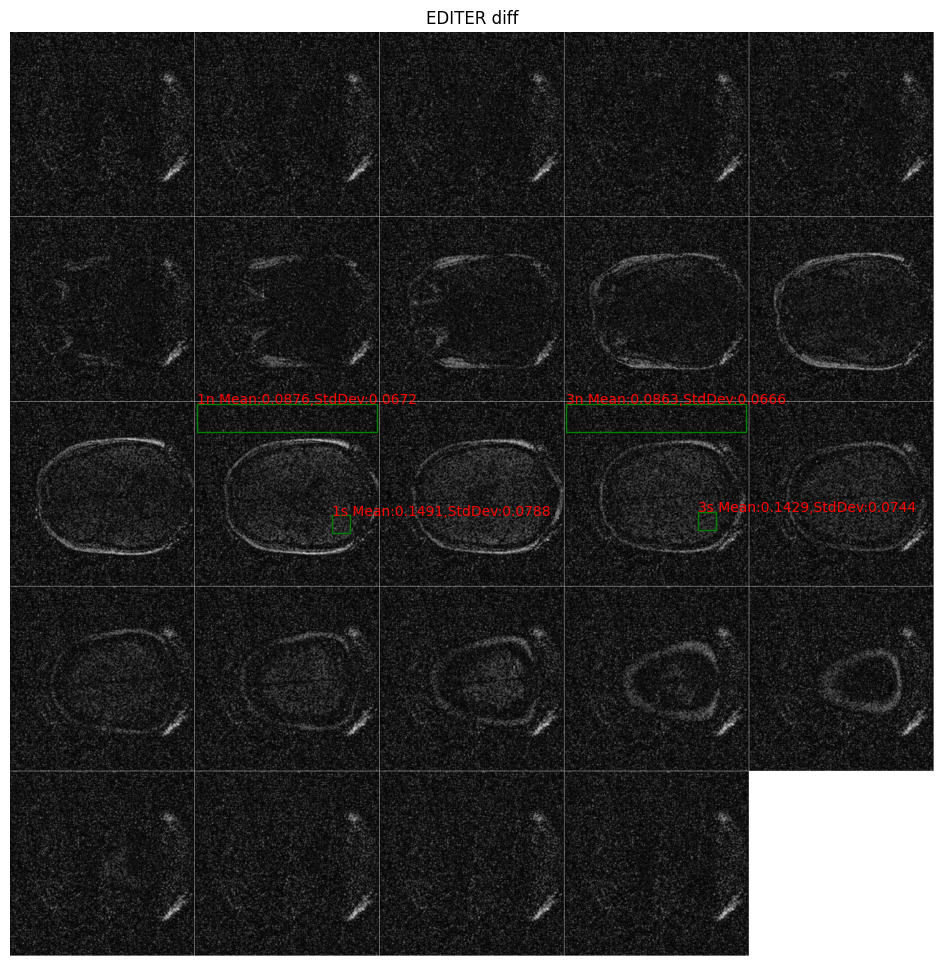

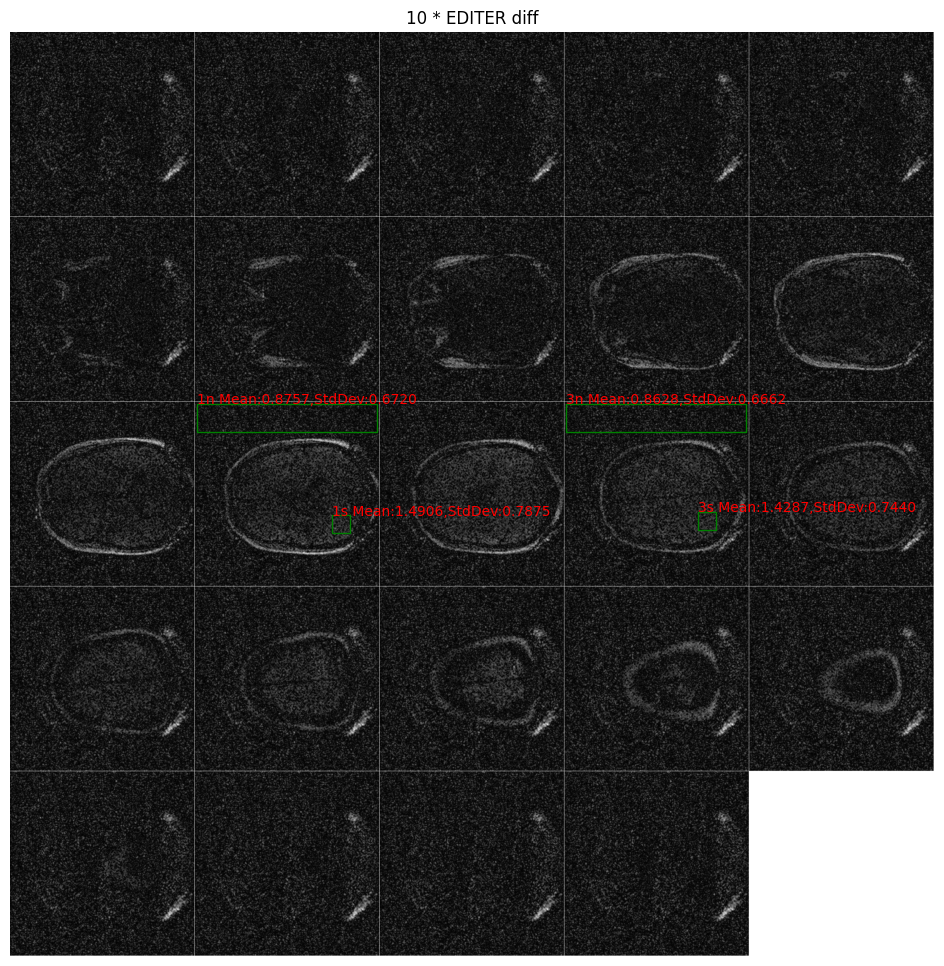

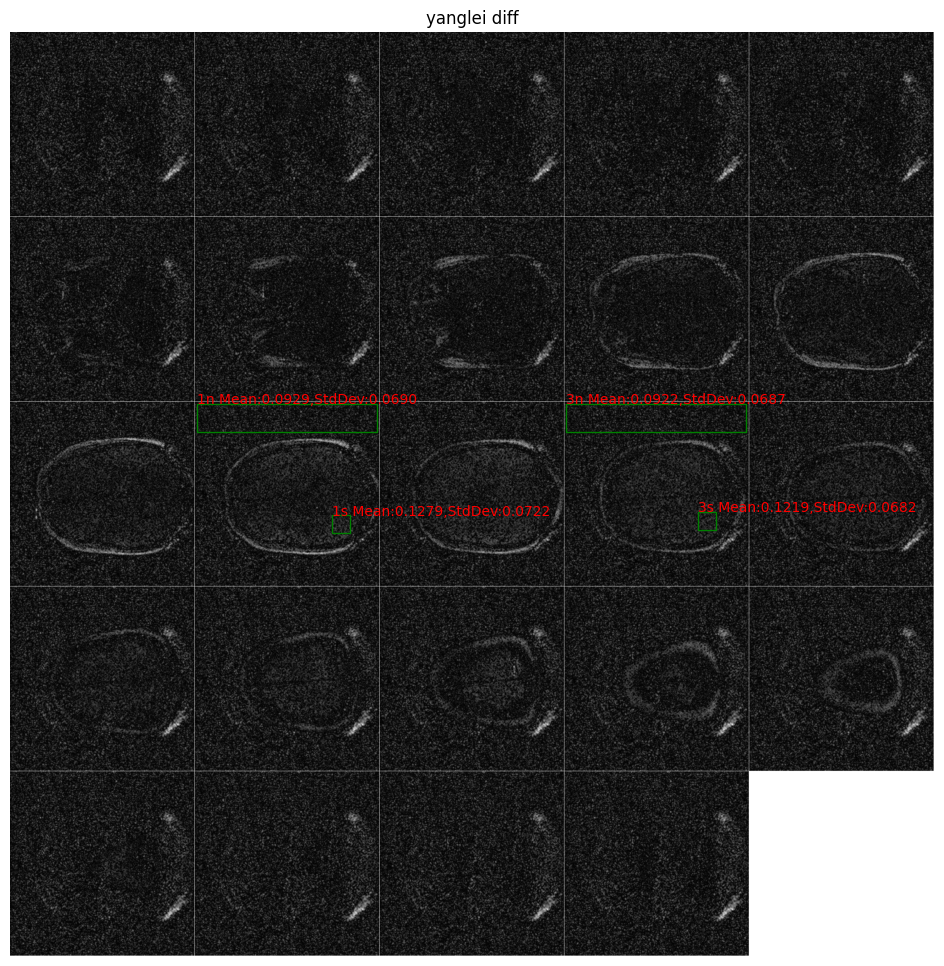

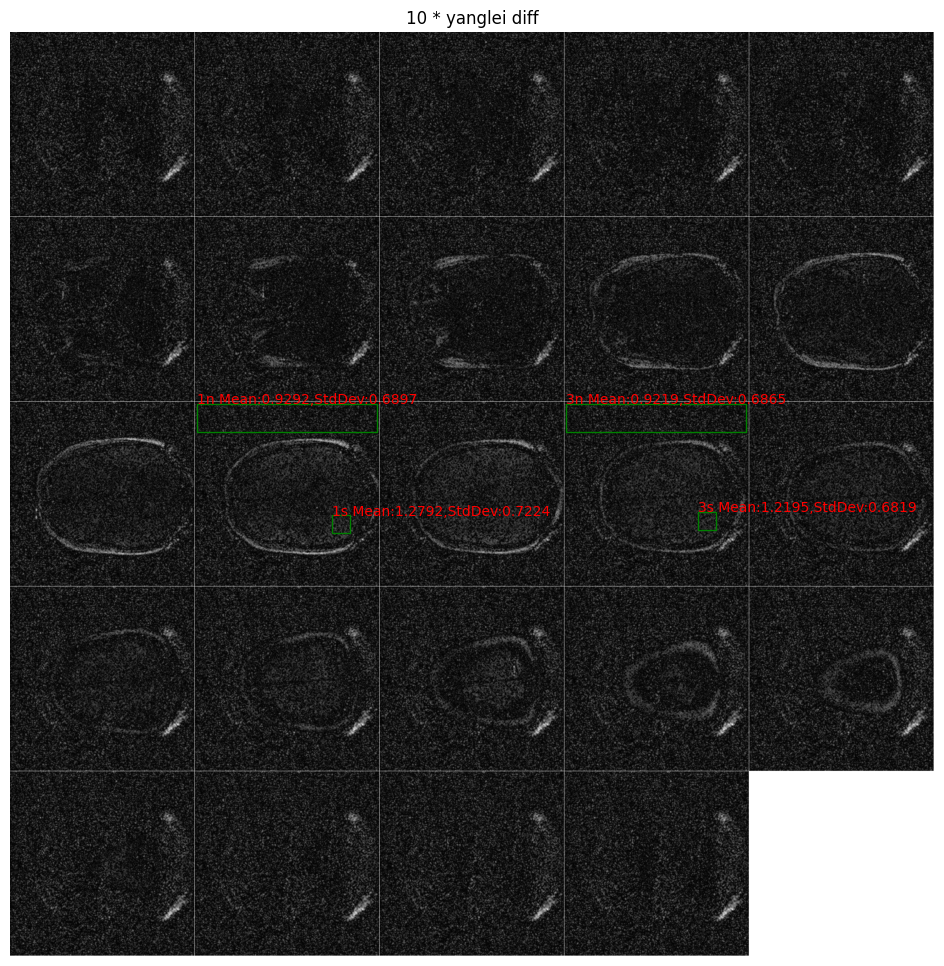

In [35]:
rois = {
    #        (row, col, x-off, y-off, width, height)
    '1n': (2, 1, 5, 5, 499, 79),
    '1s': (2, 1, 380, 315, 50, 50),
    # '2n' : (2,   0,    5,    5,     499,   79),
    # '2s' : (2,   0,   156,  170,    290,   180),
    '3n': (2, 3, 5, 5, 499, 79),
    '3s': (2, 3, 370, 305, 50, 50),
}

datas = data_loader.load_data('scan')
measured = []
editer_denoised = []
yanglei_denoised = []
for i in range(len(datas)):
    primary_coil_data, external_coils_data = datas[i]
    views, samples = primary_coil_data.shape
    measured = primary_coil_data.reshape(1, 1, 1, views, 1, samples)
    editer_denoised.append(
        editer.cancel_noise(primary_coil_data, external_coils_data).reshape(1, 1, 1, views, 1, samples))
    yanglei_denoised.append(yanglei(primary_coil_data, external_coils_data).reshape(1, 1, 1, views, 1, samples))

editer_denoised = np.array(editer_denoised).reshape(24, 1, 1, views, 1, samples)
yanglei_denoised = np.array(yanglei_denoised).reshape(24, 1, 1, views, 1, samples)
editer_denoised = np.swapaxes(editer_denoised, 0, 4)
yanglei_denoised = np.swapaxes(yanglei_denoised, 0, 4)

editer_diff = abs(reconImagesByFFT(editer_denoised, 512) - reconImagesByFFT(measured, 512))
yanglei_diff = abs(reconImagesByFFT(yanglei_denoised, 512) - reconImagesByFFT(measured, 512))

vis_square_annotate(editer_diff, rois=rois, title='EDITER diff')
vis_square_annotate(10 * editer_diff, rois=rois, title='10 * EDITER diff')

vis_square_annotate(yanglei_diff, rois=rois, title='yanglei diff')
vis_square_annotate(10 * yanglei_diff, rois=rois, title='10 * yanglei diff')
plt.show()
